In [1]:
import jax
import jax.numpy as jnp
import haiku as hk
from jax.config import config
config.update("jax_enable_x64", True)

First we explore how to use `jax` and `haiku` to build a very simple flow (diffeomorphic) layer that only uses elementwise matrix addition.

In [2]:
class TestModule():
    def __init__(self):
        self.initializer = hk.initializers.RandomNormal()
    
    def forward(self, z):
        b = hk.get_parameter("b", shape=z.shape, dtype=z.dtype, init=self.initializer)
        x = z+b
        return x
        
    def reverse(self, x):
        b = hk.get_parameter("b", shape=x.shape, dtype=x.dtype, init=self.initializer)
        z = x-b
        return z
    

In [3]:
module = TestModule()
module.forward = hk.without_apply_rng(hk.transform(module.forward))
module.reverse = hk.without_apply_rng(hk.transform(module.reverse))


In [4]:
rng_key = jax.random.PRNGKey(42)
z = jnp.ones([5,5], dtype=jnp.float64)
params = module.forward.init(rng=rng_key, z=z)
_ = module.reverse.init(rng=rng_key, x=z)

In [5]:
x = module.forward.apply(params=params, z=z)
z_ = module.reverse.apply(params=params, x=x)
print(((z - z_) < 1e-8).all()) # This checks that our forward and reverse functions are indeed inverse to each other!

True


In [6]:
params

{'~': {'b': DeviceArray([[-1.15004178,  0.04606892,  0.32795909,  0.68028659,
                 0.51907334],
               [-1.0147263 ,  1.67143453, -1.01262764, -2.04468599,
                -1.80089611],
               [ 0.36868055, -0.80086668, -0.75564312,  0.06626375,
                -1.26251544],
               [ 1.51622282,  0.39048873, -0.29448347,  0.40208557,
                 0.45007318],
               [-2.79862564,  0.70667554, -0.31695924,  1.07307229,
                 0.30801949]], dtype=float64)}}

We now proceed to build the RealNVP layer used in a lot of normalizing flow models around 2019, also used in the Boltzmann Generator paper (Noe, et al. 2019).

In [258]:
class RealNVPLayer(hk.Module):
    def __init__(self, n_channels, n_hidden=100):
        super().__init__()
        self.S = hk.nets.MLP(output_sizes=[n_hidden, n_hidden, n_hidden, n_channels], activation=jax.nn.tanh)
        self.T = hk.nets.MLP(output_sizes=[n_hidden, n_hidden, n_hidden, n_channels], activation=jax.nn.relu)
    
    def forward(self, z1, z2):
        x1 = z1
        sz1 = self.S(z1)
        x2 = (z2 - self.T(x1)) * jnp.exp(-sz1)
        logdet = -jnp.sum(sz1)
        return x1, x2, logdet 
    
    def reverse(self, x1, x2):
        z1 = x1
        sx1 = self.S(x1)
        z2 = x2 * jnp.exp(sx1) + self.T(x1)
        logdet = jnp.sum(sx1)
        return z1, z2, logdet

In [8]:
RealNVP_layer_forward = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPLayer(5).forward(z1, z2)))
RealNVP_layer_reverse = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPLayer(5).reverse(z1, z2)))
z1, z2 = jnp.ones([1, 5]), jnp.ones([1, 5])
params = RealNVP_layer_forward.init(rng_key, z1, z2)
print(params)

{'real_nvp_layer/~/linear': {'w': DeviceArray([[-0.47888951,  0.0196646 ,  0.13976707,  0.28823662,
               0.22064826],
             [-0.42528571,  0.66701922, -0.42444414, -0.77144767,
              -0.70689171],
             [ 0.15705249, -0.33823985, -0.31955111,  0.02828385,
              -0.52229106],
             [ 0.61500347,  0.16629952, -0.1255408 ,  0.17121368,
               0.19152369],
             [-0.87500178,  0.29922562, -0.13509398,  0.4485639 ,
               0.13129494]], dtype=float64), 'b': DeviceArray([0., 0., 0., 0., 0.], dtype=float64)}, 'real_nvp_layer/~/linear_1': {'w': DeviceArray([[ 0.45900732, -0.30801296, -0.16725294, -0.04993414,
              -0.51880372],
             [ 0.2882301 ,  0.09396023, -0.28322873, -0.54696708,
               0.04163422],
             [ 0.29150658,  0.58963499,  0.19386783,  0.17295861,
              -0.40755709],
             [-0.52583808,  0.60029089, -0.64019628,  0.16157535,
              -0.21730138],
            

In [9]:
x1, x2, ld1 = RealNVP_layer_forward.apply(params, z1, z2)
z1_, z2_, ld2 = RealNVP_layer_reverse.apply(params, x1, x2)

In [10]:
print(z1_, z2_, ld1, ld2)

[[1. 1. 1. 1. 1.]] [[1. 1. 1. 1. 1.]] 1.5788803821315405 -1.5788803821315405


Good, this shows that our single layer is indeed invertible. Now we define a RealNVP block by stacking two layers and swapping the channels in between.

In [260]:
class RealNVPBlock():
    def __init__(self, n_channels, n_hidden=100):
        super().__init__()
        self.layer1 = RealNVPLayer(n_channels, n_hidden)
        self.layer2 = RealNVPLayer(n_channels, n_hidden)
    
    def forward(self, z1, z2):
        y1, y2, ld1 = self.layer1.forward(z1, z2)
        x1, x2, ld2 = self.layer2.forward(y2, y1) # swap channels
        logdet = ld1 + ld2
        return x1, x2, logdet
    
    def reverse(self, x1, x2):
        y1, y2, ld1 = self.layer2.reverse(x1, x2)
        z1, z2, ld2 = self.layer1.reverse(y2, y1) # swap channels
        logdet = ld1 + ld2
        return z1, z2, logdet

In [12]:
RealNVP_block_forward = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPBlock(5).forward(z1, z2)))
RealNVP_block_reverse = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPBlock(5).reverse(z1, z2)))
params = RealNVP_block_forward.init(rng_key, z1, z2)
print(params)

{'real_nvp_layer/~/linear': {'w': DeviceArray([[-0.47888951,  0.0196646 ,  0.13976707,  0.28823662,
               0.22064826],
             [-0.42528571,  0.66701922, -0.42444414, -0.77144767,
              -0.70689171],
             [ 0.15705249, -0.33823985, -0.31955111,  0.02828385,
              -0.52229106],
             [ 0.61500347,  0.16629952, -0.1255408 ,  0.17121368,
               0.19152369],
             [-0.87500178,  0.29922562, -0.13509398,  0.4485639 ,
               0.13129494]], dtype=float64), 'b': DeviceArray([0., 0., 0., 0., 0.], dtype=float64)}, 'real_nvp_layer/~/linear_1': {'w': DeviceArray([[ 0.45900732, -0.30801296, -0.16725294, -0.04993414,
              -0.51880372],
             [ 0.2882301 ,  0.09396023, -0.28322873, -0.54696708,
               0.04163422],
             [ 0.29150658,  0.58963499,  0.19386783,  0.17295861,
              -0.40755709],
             [-0.52583808,  0.60029089, -0.64019628,  0.16157535,
              -0.21730138],
            

In [13]:
x1, x2, ld1 = RealNVP_block_forward.apply(params, z1, z2)
z1_, z2_, ld2 = RealNVP_block_reverse.apply(params, x1, x2)
print(z1_, z2_, ld1, ld2)

[[1. 1. 1. 1. 1.]] [[1. 1. 1. 1. 1.]] 4.466600014641012 -4.466600014641011


Great, so far so good. We see that the block as implemented is invertible. The BG network in the original paper is composed of multiple such blocks, so we proceed to build this.

In [290]:
class RealNVPStack():
    def __init__(self, n_channels, n_stacks, n_hidden=100):
        super().__init__()
        self.layers = [RealNVPBlock(n_channels, n_hidden) for _ in range(n_stacks)]
    
    def forward(self, z1, z2):
        logdet = 0
        for layer in self.layers:
            z1, z2, ld = layer.forward(z1, z2)
            logdet += ld
        return z1, z2, logdet
    
    def reverse(self, x1, x2):
        logdet = 0
        for layer in self.layers[::-1]:
            x1, x2, ld = layer.reverse(x1, x2)
            logdet += ld
        return x1, x2, logdet

Next, we remind ourselves that the idea of flow model is simple, that is, we want to use a diffeomorphism to reshape a complicated unknown distribution into a simpler distribution (of the same dimension), say a Gaussian. To demonstrate this idea let us try modeling the empirical distribution over the swiss roll dataset with a single RealNVP block.

In [301]:
from sklearn.datasets import make_swiss_roll
import matplotlib.pyplot as plt

X, _ = make_swiss_roll(n_samples=1000, random_state=42, noise=0.5)
X = X[:, [0, 2]]
print(X.shape)

(1000, 2)


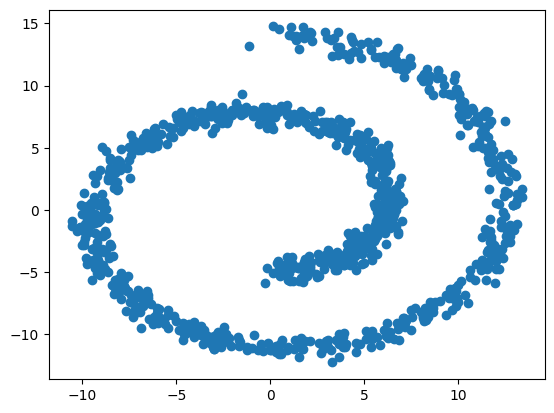

In [302]:
plt.scatter(X[:,0], X[:,1])

Since we can sample from the target distribution but not necessarily compute the empirical density, it's more apt to use the forward KL divergence and its Monte Carlo estimator:

$$
\mathcal{L} = D_{KL}[p_x^* || p_x] \approx -\frac{1}{N} \sum_{n=1}^N \log p_u (z_n) + \log \det J_{f^{-1}}(x_n)
$$

Note, if we fix the base distribution to be a standard Gaussian, then the first term is simply half of the sum of the squares, and the second term is easily computed due to our choice of a simple invertible function (RealNVP blocks).

We will optimize function parameters iteratively use minibatch + SGD and this will be done with jax.

In [322]:
batch_size, n_hidden, n_channels, n_layers = 100, 4, 1, 4
RealNVP_stack_forward = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPStack(n_channels, n_layers, n_hidden).forward(z1, z2)))
RealNVP_stack_reverse = hk.without_apply_rng(hk.transform(lambda z1, z2: RealNVPStack(n_channels, n_layers, n_hidden).reverse(z1, z2)))
z1, z2 = jnp.ones([batch_size, n_channels]), jnp.ones([batch_size, n_channels])
params = RealNVP_stack_forward.init(rng_key, z1, z2)

In [323]:
params

{'real_nvp_layer/~/mlp/~/linear_0': {'w': DeviceArray([[-0.7216041 ,  0.81626981, -0.13628885, -0.69863052]], dtype=float64),
  'b': DeviceArray([0., 0., 0., 0.], dtype=float64)},
 'real_nvp_layer/~/mlp/~/linear_1': {'w': DeviceArray([[ 0.6234449 , -0.04051315,  0.39043091, -0.11083835],
               [-0.27759754,  0.34556775, -0.47800515, -0.24940889],
               [ 0.13050417, -0.40037879,  0.69214724,  0.01610381],
               [-0.49530807, -0.37968512,  0.52538027,  0.65554868]],            dtype=float64),
  'b': DeviceArray([0., 0., 0., 0.], dtype=float64)},
 'real_nvp_layer/~/mlp/~/linear_2': {'w': DeviceArray([[ 0.8429256 ,  0.08052766, -0.76829145, -0.22958255],
               [-0.4593895 ,  0.40525453, -0.09072433,  0.05627559],
               [-0.37920854, -0.02320201,  0.73988111, -0.7274192 ],
               [ 0.64048618,  0.11764015,  0.3115064 ,  0.22419273]],            dtype=float64),
  'b': DeviceArray([0., 0., 0., 0.], dtype=float64)},
 'real_nvp_layer/~/mlp/~

In [324]:
import optax

def loss_fn(params, batch): # x.shape = n_batch, 2 * n_channels
    loss = 0
    x1, x2 = batch[:, :n_channels], batch[:, n_channels:]
    #jax.debug.print('{x1}, {x2}', x1=x1.shape, x2=x2.shape)
    z1, z2, ldj = RealNVP_stack_reverse.apply(params, x1, x2)
    #jax.debug.print('{z1}, {z2}', z1=z1, z2=z2)
    loss += -jnp.sum(optax.l2_loss(z1))
    #jax.debug.print('{loss}', loss=z1)
    loss += -jnp.sum(optax.l2_loss(z2))
    loss += jnp.sum(ldj)
    return -loss / batch_size
    

In [325]:
training_data = jnp.reshape(X, (10, batch_size, 2*n_channels))

In [326]:
def fit(params, optimizer, epochs) -> optax.Params:
    opt_state = optimizer.init(params)
    
    @jax.jit
    def step(params, opt_state, batch):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, batch)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    z_new = jax.random.normal(rng_key, shape=(1000, 2))
    for epoch in range(epochs):
        for i, batch in enumerate(training_data):
            params, opt_state, loss_value = step(params, opt_state, batch)
        print(f'Loss: {loss_value}')
        x_new1, x_new2, _ = RealNVP_stack_forward.apply(params, z_new[:,0:1], z_new[:,1:2])
        #plt.scatter(x_new1, x_new2)
    return params

In [353]:
optimizer = optax.adam(learning_rate=1e-3)
params = fit(params, optimizer, 500)

Loss: 3.7872704628856115
Loss: 3.736603411576541
Loss: 3.744309676681679
Loss: 3.7094121218217486
Loss: 3.7138028931366716
Loss: 3.716723740458647
Loss: 3.6960764883900037
Loss: 3.715968163970737
Loss: 3.7106126654526888
Loss: 3.6960277526177463
Loss: 3.7028686468250713
Loss: 3.704162033256383
Loss: 3.7038721027533357
Loss: 3.6986050526011947
Loss: 3.7025877084783856
Loss: 3.703660360803734
Loss: 3.7026655748362525
Loss: 3.7061514810519687
Loss: 3.705647142620036
Loss: 3.699397778981754
Loss: 3.703898582518722
Loss: 3.7054246052266864
Loss: 3.70310849900446
Loss: 3.7053807284491707
Loss: 3.7057303908006474
Loss: 3.703473089371503
Loss: 3.704983741554479
Loss: 3.7103947352159525
Loss: 3.7002835236374807
Loss: 3.705307388724923
Loss: 3.7057727526957547
Loss: 3.7038121260651953
Loss: 3.705264571679723
Loss: 3.7107541961894763
Loss: 3.7032158900298953
Loss: 3.707247670577238
Loss: 3.709335339666607
Loss: 3.7063405224417614
Loss: 3.7053827714442975
Loss: 3.7130588342648307
Loss: 3.705896826

Loss: 3.7056375900684713
Loss: 3.7029447247838414
Loss: 3.7055252992226633
Loss: 3.705141428704855
Loss: 3.7017059152737857
Loss: 3.718319510404858
Loss: 3.706315547821796
Loss: 3.705827677707197
Loss: 3.710442925319592
Loss: 3.6970071182736306
Loss: 3.7167814122496607
Loss: 3.7120742538644063
Loss: 3.7063053167535585
Loss: 3.6976115065460213
Loss: 3.7055328015087245
Loss: 3.7124638826231773
Loss: 3.712959300793708
Loss: 3.7015884110249093
Loss: 3.6992993216668513
Loss: 3.707643865740039
Loss: 3.7100710783043604
Loss: 3.7055442503655365
Loss: 3.7024607941783114
Loss: 3.7074480460644845
Loss: 3.703259242483712
Loss: 3.705078343470666
Loss: 3.7014304813264958
Loss: 3.7018283590774086
Loss: 3.702896107863111
Loss: 3.7070638980018886
Loss: 3.703933578337492
Loss: 3.704568700840198
Loss: 3.704909103304473
Loss: 3.696989830873287
Loss: 3.708236151651339
Loss: 3.7039871369209885
Loss: 3.71012188393215
Loss: 3.699539771010732
Loss: 3.7053904897995746
Loss: 3.7068248105291755
Loss: 3.7029391810

In [354]:
z_new = jax.random.normal(rng_key, shape=(1000, 2))

In [355]:
x_new1, x_new2, _ = RealNVP_stack_forward.apply(params, z_new[:,0:1], z_new[:,1:2])

(-20.0, 20.0)

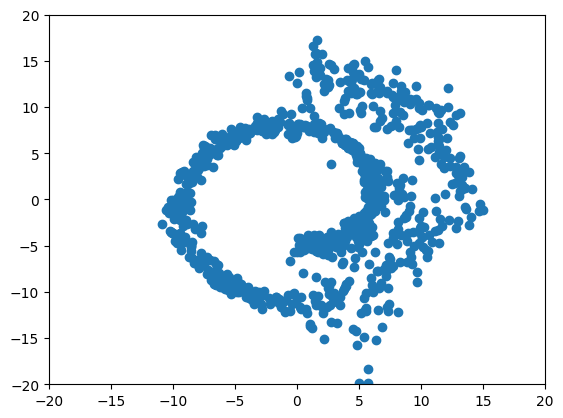

In [356]:
plt.scatter(x_new1, x_new2)
plt.xlim([-20, 20])
plt.ylim([-20, 20])

We see that the result is pretty decent compared to the initial training dataset, considering we only used 3 hidden layers each with only four neurons! Let us save the results and go to study the bistable model system used in the paper.

In [360]:
import pickle
with open('./swiss_roll_generator_params.pkl', 'wb') as file:
    pickle.dump(params, file)